<a href="https://colab.research.google.com/github/svetlanama/goit-np-hw-01/blob/main/NP_HW_09.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# ========================================
# Імпорт бібліотек та створення середовища
# ========================================

import gym
import numpy as np
import matplotlib.pyplot as plt

# Функція для візуалізації (ОНОВЛЕНА)
def show_render(img):
    """Відображає зображення середовища"""
    # Перевірка чи img є tuple/list
    if isinstance(img, (tuple, list)):
        img = img[0]

    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Створення середовища
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True, render_mode="rgb_array")

print(f"Кількість станів: {env.observation_space.n}")
print(f"Кількість дій: {env.action_space.n}")
print(f"\nОпис дій:")
print("0: LEFT (Ліворуч)")
print("1: DOWN (Вниз)")
print("2: RIGHT (Праворуч)")
print("3: UP (Вгору)")

Кількість станів: 16
Кількість дій: 4

Опис дій:
0: LEFT (Ліворуч)
1: DOWN (Вниз)
2: RIGHT (Праворуч)
3: UP (Вгору)


/usr/local/lib/python3.12/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.12/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Початковий стан середовища:


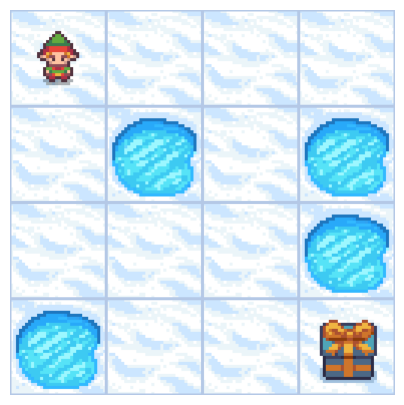


Дія 1: 0


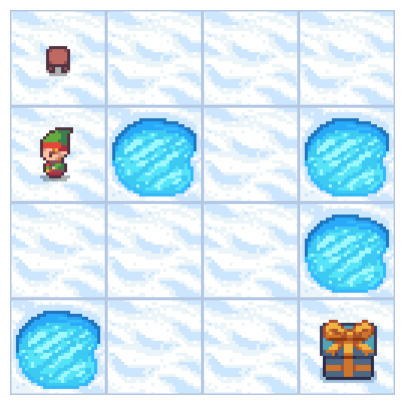


Дія 2: 0


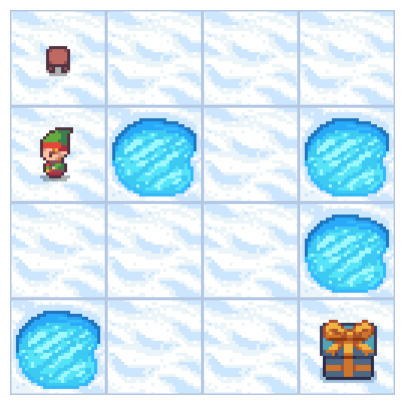


Дія 3: 0


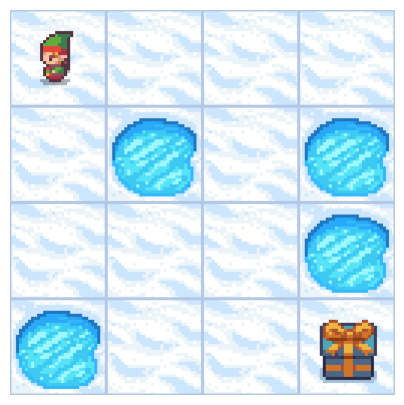

In [7]:
# ========================================
# Демонстрація середовища (ОНОВЛЕНА)
# ========================================

# Ініціалізація середовища
observation = env.reset()
if isinstance(observation, tuple):
    observation = observation[0]

# Початковий стан
print("Початковий стан середовища:")
show_render(env.render())

# Випадкові дії для демонстрації
for i in range(3):
    action = env.action_space.sample()
    print(f"\nДія {i+1}: {action}")

    result = env.step(action)
    if len(result) == 5:
        observation, reward, done, truncated, info = result
        done = done or truncated
    else:
        observation, reward, done, info = result

    show_render(env.render())

    if done:
        print("Епізод завершено!")
        observation = env.reset()
        if isinstance(observation, tuple):
            observation = observation[0]
        break

In [8]:
# ========================================
# Функція compute_value_function()
# ========================================

def compute_value_function(policy, gamma=1.0, theta=1e-10):
    """
    Обчислює функцію цінності для заданої політики (Policy Evaluation).

    Параметри:
    - policy: масив, що визначає дію для кожного стану
    - gamma: коефіцієнт дисконтування
    - theta: поріг збіжності

    Повертає:
    - value_function: масив значень цінності для кожного стану
    """
    # Ініціалізація функції цінності нулями
    value_function = np.zeros(env.observation_space.n)

    while True:
        delta = 0

        # Для кожного стану
        for state in range(env.observation_space.n):
            # Зберігаємо стару цінність
            old_value = value_function[state]

            # Отримуємо дію з політики
            action = int(policy[state])

            # Обчислюємо нову цінність стану
            new_value = 0

            # env.P[state][action] містить список кортежів (ймовірність, наступний_стан, винагорода, завершено)
            for probability, next_state, reward, done in env.P[state][action]:
                new_value += probability * (reward + gamma * value_function[next_state])

            # Оновлюємо функцію цінності
            value_function[state] = new_value

            # Обчислюємо максимальну зміну
            delta = max(delta, abs(old_value - new_value))

        # Перевірка збіжності
        if delta < theta:
            break

    return value_function

In [9]:
# ========================================
# Функція extract_policy()
# ========================================

def extract_policy(value_function, gamma=1.0):
    """
    Витягує політику з функції цінності.

    Параметри:
    - value_function: функція цінності
    - gamma: коефіцієнт дисконтування

    Повертає:
    - policy: жадібна політика відносно value_function
    """
    policy = np.zeros(env.observation_space.n)

    for state in range(env.observation_space.n):
        # Обчислюємо Q-значення для всіх дій
        q_values = np.zeros(env.action_space.n)

        for action in range(env.action_space.n):
            # Для кожної дії обчислюємо очікуване значення
            for probability, next_state, reward, done in env.P[state][action]:
                q_values[action] += probability * (reward + gamma * value_function[next_state])

        # Вибираємо дію з максимальним Q-значенням
        policy[state] = np.argmax(q_values)

    return policy

In [10]:
# ========================================
# Функція policy_iteration()
# ========================================

def policy_iteration(gamma=1.0, max_iterations=1000):
    """
    Алгоритм Policy Iteration для знаходження оптимальної політики.

    Параметри:
    - gamma: коефіцієнт дисконтування
    - max_iterations: максимальна кількість ітерацій

    Повертає:
    - optimal_policy: оптимальна політика
    - optimal_value_function: оптимальна функція цінності
    """
    # Ініціалізація випадкової політики (всі дії = 0)
    old_policy = np.zeros(env.observation_space.n)

    print("Початок Policy Iteration...\n")

    for i in range(max_iterations):
        # Policy Evaluation: обчислюємо функцію цінності для поточної політики
        new_value_function = compute_value_function(old_policy, gamma)

        # Policy Improvement: витягуємо нову політику з функції цінності
        new_policy = extract_policy(new_value_function, gamma)

        # Перевірка збіжності
        if np.all(old_policy == new_policy):
            print(f'Policy Iteration збігся на кроці {i+1}.')
            break

        # Оновлюємо політику
        old_policy = new_policy

        if (i+1) % 10 == 0:
            print(f"Ітерація {i+1}...")

    return new_policy, new_value_function

In [11]:
# ========================================
# Виконання Policy Iteration
# ========================================

# Виконуємо Policy Iteration
optimal_policy, optimal_value_function = policy_iteration(gamma=0.99)

print("\n=== Оптимальна політика ===")
print(optimal_policy)
print("\n=== Оптимальна функція цінності ===")
print(optimal_value_function)

Початок Policy Iteration...

Policy Iteration збігся на кроці 7.

=== Оптимальна політика ===
[0. 3. 3. 3. 0. 0. 0. 0. 3. 1. 0. 0. 0. 2. 1. 0.]

=== Оптимальна функція цінності ===
[0.54202593 0.49880319 0.47069569 0.4568517  0.55845096 0.
 0.35834807 0.         0.59179874 0.64307982 0.61520756 0.
 0.         0.74172044 0.86283743 0.        ]


In [12]:
# ========================================
# Візуалізація оптимальної політики
# ========================================

def print_policy(policy):
    """
    Візуалізує політику у вигляді сітки 4x4 зі стрілками.
    """
    actions_symbols = ['←', '↓', '→', '↑']
    policy_grid = np.array([actions_symbols[int(action)] for action in policy]).reshape(4, 4)

    print("\nВізуалізація оптимальної політики (4x4):")
    print("S - Старт, F - Заморожене, H - Діра, G - Ціль\n")

    for i in range(4):
        row = ""
        for j in range(4):
            row += f"{policy_grid[i, j]}  "
        print(row)

print_policy(optimal_policy)

# Візуалізація функції цінності
print("\n=== Функція цінності (сітка 4x4) ===")
value_grid = optimal_value_function.reshape(4, 4)
for row in value_grid:
    print(' '.join([f'{val:6.3f}' for val in row]))


Візуалізація оптимальної політики (4x4):
S - Старт, F - Заморожене, H - Діра, G - Ціль

←  ↑  ↑  ↑  
←  ←  ←  ←  
↑  ↓  ←  ←  
←  →  ↓  ←  

=== Функція цінності (сітка 4x4) ===
 0.542  0.499  0.471  0.457
 0.558  0.000  0.358  0.000
 0.592  0.643  0.615  0.000
 0.000  0.742  0.863  0.000


In [13]:
# ========================================
# Тестування оптимальної політики
# ========================================

def test_policy(policy, num_episodes=100):
    """
    Тестує політику на заданій кількості епізодів.
    """
    wins = 0

    for episode in range(num_episodes):
        state = env.reset()
        if isinstance(state, tuple):
            state = state[0]
        done = False

        while not done:
            action = int(policy[state])
            result = env.step(action)

            if len(result) == 5:
                state, reward, done, truncated, info = result
                done = done or truncated
            else:
                state, reward, done, info = result

            if done and reward == 1.0:
                wins += 1
                break

    win_rate = (wins / num_episodes) * 100
    print(f"\n=== Результати тестування ===")
    print(f"Кількість епізодів: {num_episodes}")
    print(f"Перемоги: {wins}")
    print(f"Відсоток успіху: {win_rate:.2f}%")

    return win_rate

# Тестуємо оптимальну політику
test_policy(optimal_policy, num_episodes=1000)


=== Результати тестування ===
Кількість епізодів: 1000
Перемоги: 736
Відсоток успіху: 73.60%


73.6


=== Демонстрація оптимальної політики ===
Початковий стан:


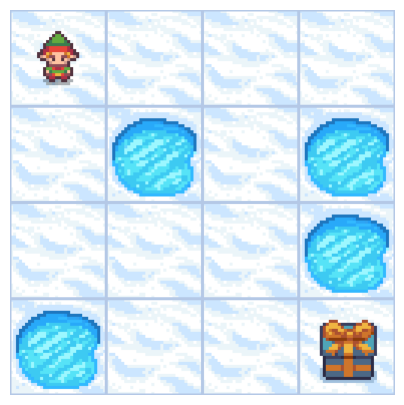


Крок 1: Стан 0, Дія: LEFT (0)


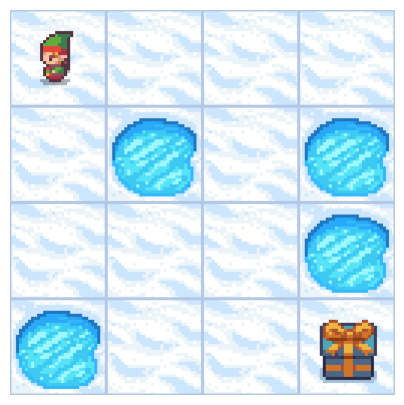


Крок 2: Стан 0, Дія: LEFT (0)


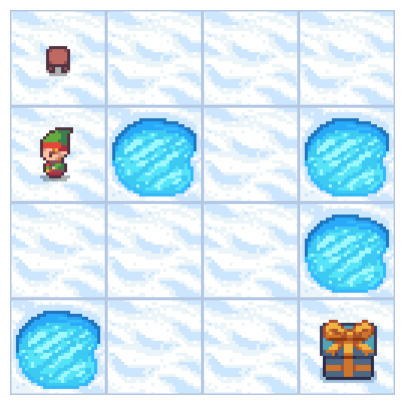


Крок 3: Стан 4, Дія: LEFT (0)


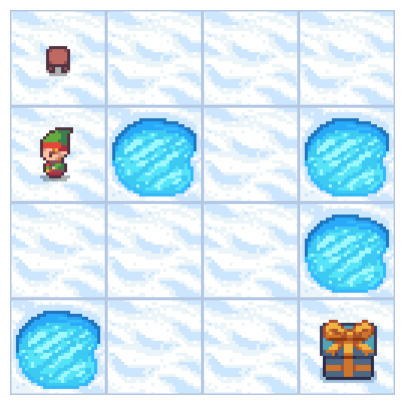


Крок 4: Стан 4, Дія: LEFT (0)


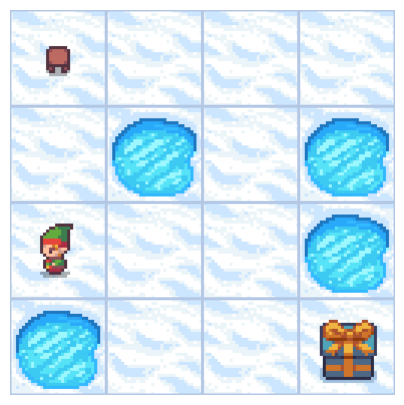


Крок 5: Стан 8, Дія: UP (3)


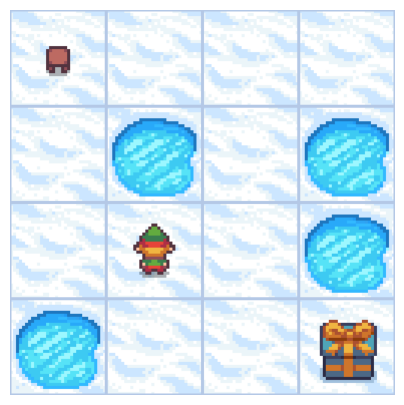


Крок 6: Стан 9, Дія: DOWN (1)


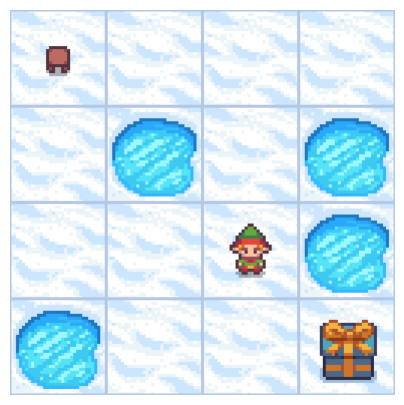


Крок 7: Стан 10, Дія: LEFT (0)


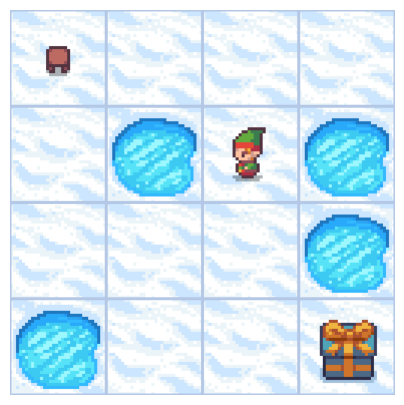


Крок 8: Стан 6, Дія: LEFT (0)


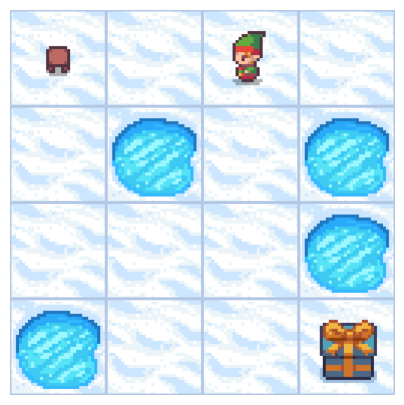


Крок 9: Стан 2, Дія: UP (3)


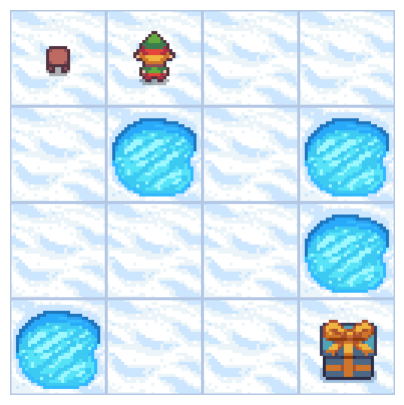


Крок 10: Стан 1, Дія: UP (3)


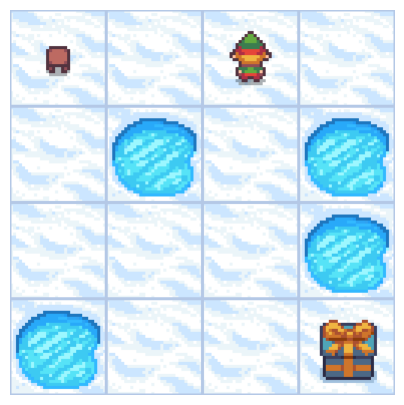


Крок 11: Стан 2, Дія: UP (3)


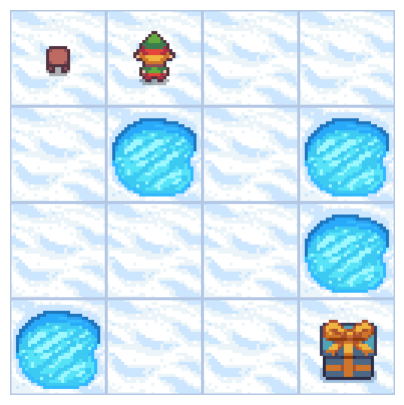


Крок 12: Стан 1, Дія: UP (3)


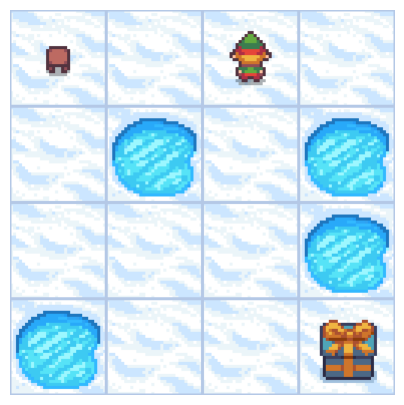


Крок 13: Стан 2, Дія: UP (3)


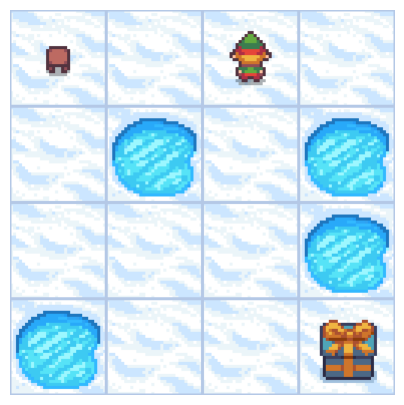


Крок 14: Стан 2, Дія: UP (3)


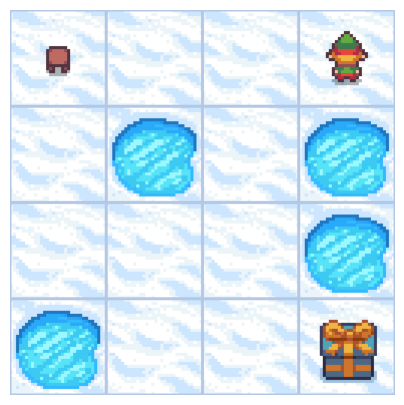


Крок 15: Стан 3, Дія: UP (3)


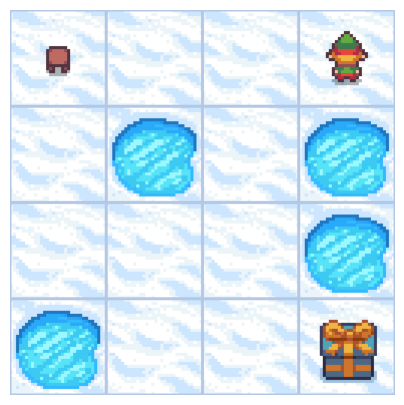

In [15]:
# ========================================
# Демонстрація роботи оптимальної політики
# ========================================

def demonstrate_policy(policy, num_steps=15):
    """
    Демонструє роботу політики з візуалізацією.
    """
    state = env.reset()
    if isinstance(state, tuple):
        state = state[0]

    print("Початковий стан:")
    show_render(env.render())

    actions_names = ['LEFT', 'DOWN', 'RIGHT', 'UP']

    for step in range(num_steps):
        action = int(policy[state])
        print(f"\nКрок {step+1}: Стан {state}, Дія: {actions_names[action]} ({action})")

        result = env.step(action)
        if len(result) == 5:
            state, reward, done, truncated, info = result
            done = done or truncated
        else:
            state, reward, done, info = result

        show_render(env.render())

        if done:
            if reward == 1.0:
                print("\n🎉 УСПІХ! Досягнуто цілі!")
            else:
                print("\n❌ Провалилися в діру!")
            break

# Демонстрація
print("\n=== Демонстрація оптимальної політики ===")
demonstrate_policy(optimal_policy)